### Neural Networks to fit $y = \sin(\theta)$ and $\theta = \arcsin(y)$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [47]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_cos, make_dataset_cos
from polar_coord import make_model_cos_math, make_model_even, make_model_odd, make_model_pow
from polar_coord import compile_and_fit, make_model_autoencoder

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [0, \pi]$ and $x \in [-1, 1]$

In [6]:
# Make datasets for sin
n = 3600
data_cos = make_data_cos(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_cos(n)

In [7]:
# Unpack one example batch
# theta, y = list(ds_p2c.take(1))[0]
# theta, y = theta.numpy(), y.numpy()

# Review data contents
# print(f'theta: min={np.min(theta):+8.5}, max={np.max(theta):+8.5}')
# print(f'    y: min={np.min(y):+8.5}, max={np.max(y):+8.5}')

In [8]:
theta = data_cos['theta']
x = data_cos['x']

## Deterministic Mathematical Models

In [9]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_model_cos_math()

In [10]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

# Set save_freq in terms of SAMPLES; this is every 500 epochs
epoch_size = n+1
save_freq = 500 * epoch_size

In [11]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [12]:
# Evaluate the p2c math model
math_p2c.evaluate(ds_p2c)

1/1 [==============================] - 0s 61ms/step - loss: 1.3505e-15 - mean_absolute_error: 2.3133e-08


[1.3505262717612015e-15, 2.3133012e-08]

In [13]:
# Evaluate the c2p math model
math_c2p.evaluate(ds_c2p)

1/1 [==============================] - 0s 53ms/step - loss: 6.5484e-13 - mean_absolute_error: 1.1456e-07


[6.548365907681208e-13, 1.1456084e-07]

In [14]:
# Evaluate the p2p math model
math_p2p.evaluate(theta, theta)

3601/3601 [==============================] - 0s 41us/sample - loss: 6.5136e-13 - mean_absolute_error: 9.4781e-08


[6.513579200136055e-13, 9.47809e-08]

In [15]:
# Evaluate the c2c math model
math_c2c.evaluate(x, x)

3601/3601 [==============================] - 0s 41us/sample - loss: 2.4611e-15 - mean_absolute_error: 3.1315e-08


[2.4610671983658676e-15, 3.1314702e-08]

## Functions for visualizing neural network outputs $x = \cos(\theta)$

In [16]:
def plot_pred_cos(model, theta):
    # Predictions of the model
    x_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$x = \\cos(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$x$')
    ax.set_xlim(0.0, np.pi)
    ax.set_xticks(np.linspace(0.0, np.pi, 5))
    ax.set_xticklabels(['$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.set_ylim(-1.05, 1.05)
    ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, x, color='blue', label='$\cos(\\theta)$', linewidth=4.0)
    ax.plot(theta, x_pred, color='red', label='NN$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [17]:
def plot_error_cos(model, theta):
    # Predictions of the model
    x_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    error = x_pred - np.cos(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $x = \\cos(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('error = $\cos(\\theta)$ - NN($\\theta$)')
    ax.set_xlim(0.0, np.pi)
    ax.set_xticks(np.linspace(0.0, np.pi, 5))
    ax.set_xticklabels(['$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(theta, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

## Neural networks for $x = \cos(\theta)$

### Network Design 1: [64]
(model_cos_64 has one layer with 64 hidden units)

In [18]:
# Build the NN model of y=sin(theta)
model_cos_64 = make_model_even(func_name='cos', 
                               input_name='theta',
                               output_name='x',
                               hidden_sizes=[64])

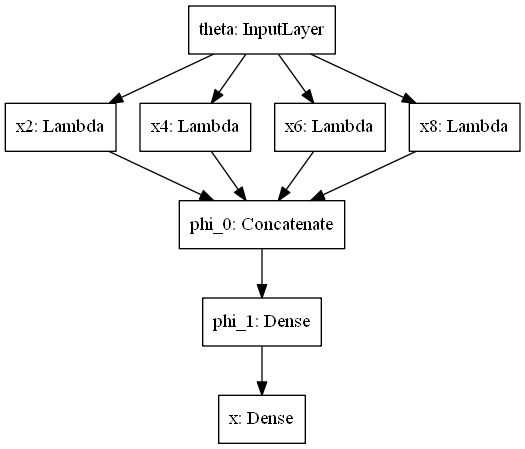

In [19]:
keras.utils.plot_model(model_cos_64)

In [20]:
model_cos_64.summary()

Model: "model_cos_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x2 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x4 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x6 (Lambda)                     (None, 1)            0           theta[0][0]                      
_____________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [21]:
loss=keras.losses.MeanSquaredError()

optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)
# optimizer=keras.optimizers.Adadelta(learning_rate=1.0E-1)
# optimizer=keras.optimizers.SGD(learning_rate=1.0E-3, momentum=0.5)

try:
    model_cos_64.load_weights('../models/polar/model_cos_[64].h5')
    model_cos_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_cos_64 = vartbl['hist_cos_64']
    print('Loaded model_cos_64.')
except:
    hist = compile_and_fit(model=model_cos_64, 
                           ds=ds_p2c, 
                           epochs=10000,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_cos_64 = hist.history
    vartbl['hist_cos_64'] = hist_cos_64
    save_vartbl(vartbl, fname)

Loaded model_cos_64.


In [22]:
model_cos_64.evaluate(ds_p2c)

1/1 [==============================] - 0s 463ms/step - loss: 3.7588e-06 - mean_absolute_error: 0.0013


[3.7587712995446054e-06, 0.0012862852]

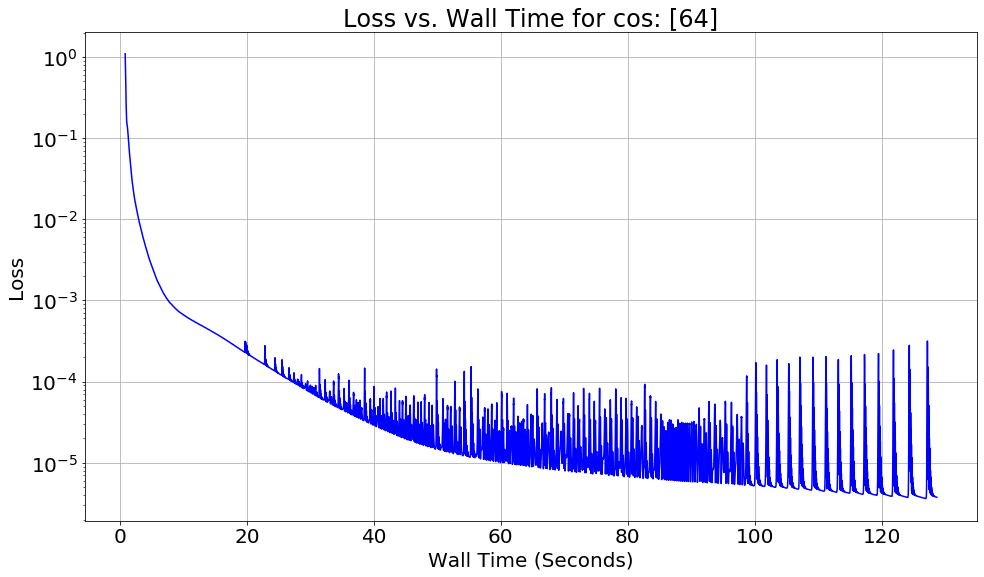

In [23]:
fig, ax = plot_loss_hist(hist_cos_64, 'cos: [64]')

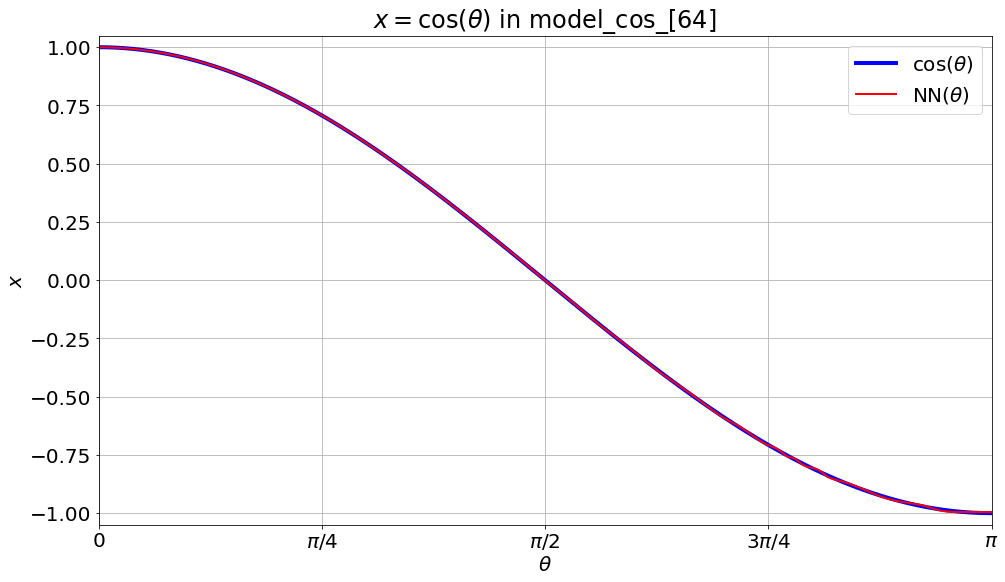

In [24]:
fig, ax = plot_pred_cos(model_cos_64, theta)

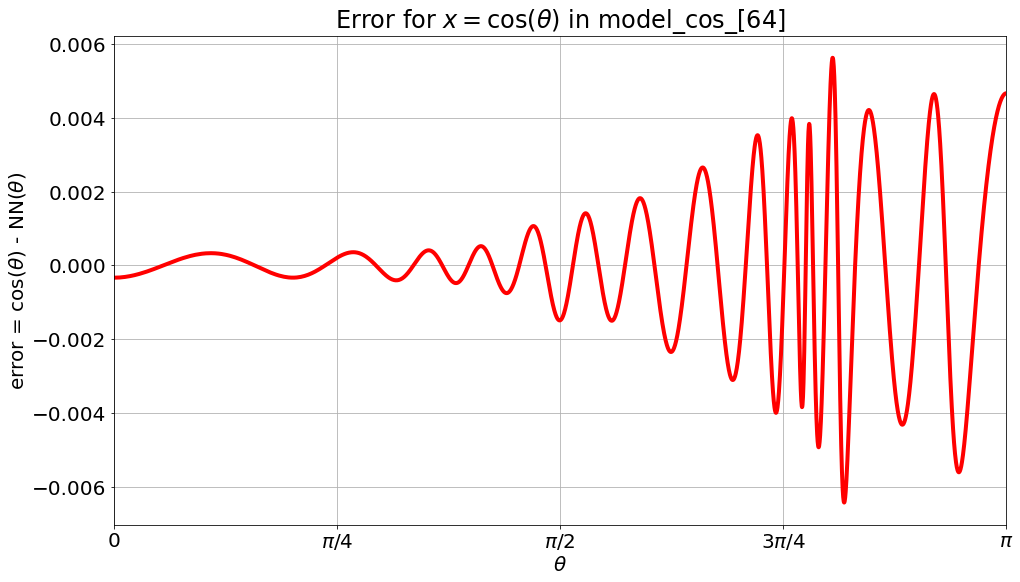

In [25]:
fig, ax = plot_error_cos(model_cos_64, theta)

### Network Design 2: [16, 16]
(model_cos_16_16 has two layers with 16 hidden units each)

In [38]:
model_cos_16_16 = make_model_even(func_name='cos', 
                                  input_name='theta',
                                  output_name='x', 
                                  hidden_sizes=[16, 16])

In [39]:
model_cos_16_16.summary()

Model: "model_cos_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x2 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x4 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x6 (Lambda)                     (None, 1)            0           theta[0][0]                      
_________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [40]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_cos_16_16.load_weights('../models/polar/model_cos_[16, 16].h5')
    model_cos_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_cos_16_16 = vartbl['hist_cos_16_16']
    print('Loaded model_cos_16_16.')
except:
    hist = compile_and_fit(model=model_cos_16_16, 
                           ds=ds_p2c, 
                           epochs=10000,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_cos_16_16 = hist.history
    vartbl['hist_cos_16_16'] = hist_cos_16_16
    save_vartbl(vartbl, fname)

W0623 16:15:44.399068 37168 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 0001; loss 7.82e-01; elapsed 0:00:00
Epoch 0500; loss 1.91e-03; elapsed 0:00:09
Epoch 1000; loss 1.03e-03; elapsed 0:00:17
Epoch 1500; loss 7.82e-04; elapsed 0:00:25
Epoch 2000; loss 2.87e-04; elapsed 0:00:33
Epoch 2500; loss 1.46e-04; elapsed 0:00:41
Epoch 3000; loss 8.23e-05; elapsed 0:00:48
Epoch 3500; loss 6.15e-05; elapsed 0:00:55
Epoch 4000; loss 4.59e-05; elapsed 0:01:02
Epoch 4500; loss 5.39e-05; elapsed 0:01:09
Epoch 5000; loss 7.71e-05; elapsed 0:01:16
Epoch 5500; loss 2.66e-05; elapsed 0:01:23
Epoch 6000; loss 2.34e-05; elapsed 0:01:30
Epoch 6500; loss 2.16e-05; elapsed 0:01:37
Epoch 7000; loss 1.77e-05; elapsed 0:01:44
Epoch 7500; loss 1.79e-05; elapsed 0:01:51
Epoch 8000; loss 3.18e-05; elapsed 0:01:58
Epoch 8500; loss 2.06e-05; elapsed 0:02:05
Epoch 9000; loss 1.56e-05; elapsed 0:02:12
Epoch 9500; loss 4.03e-05; elapsed 0:02:19
Epoch 10000; loss 9.88e-06; elapsed 0:02:26


In [41]:
model_cos_16_16.evaluate(ds_p2c)

1/1 [==============================] - 0s 104ms/step - loss: 9.8592e-06 - mean_absolute_error: 0.0022


[9.859156307356898e-06, 0.0021710098]

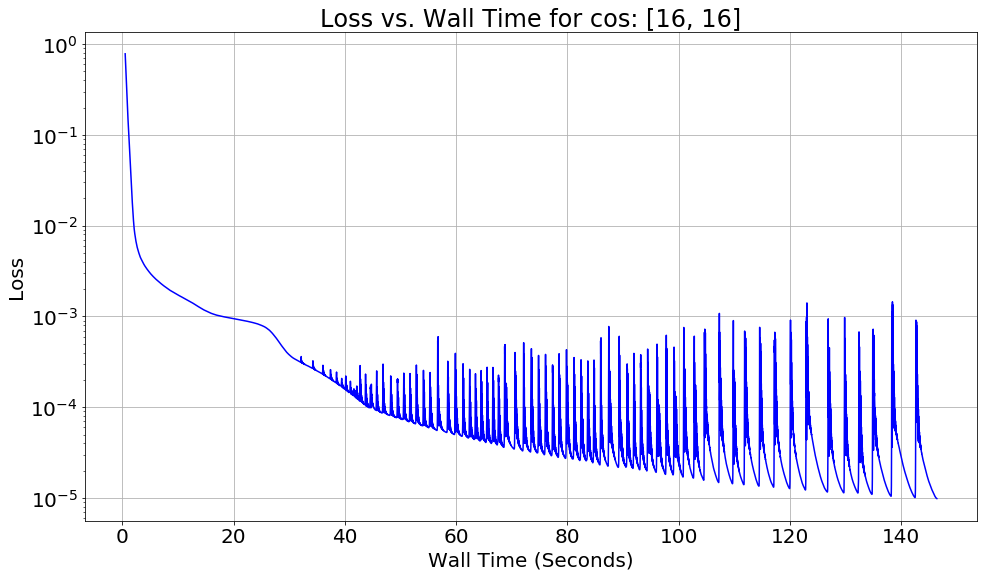

In [42]:
fig, ax = plot_loss_hist(hist_cos_16_16, 'cos: [16, 16]')

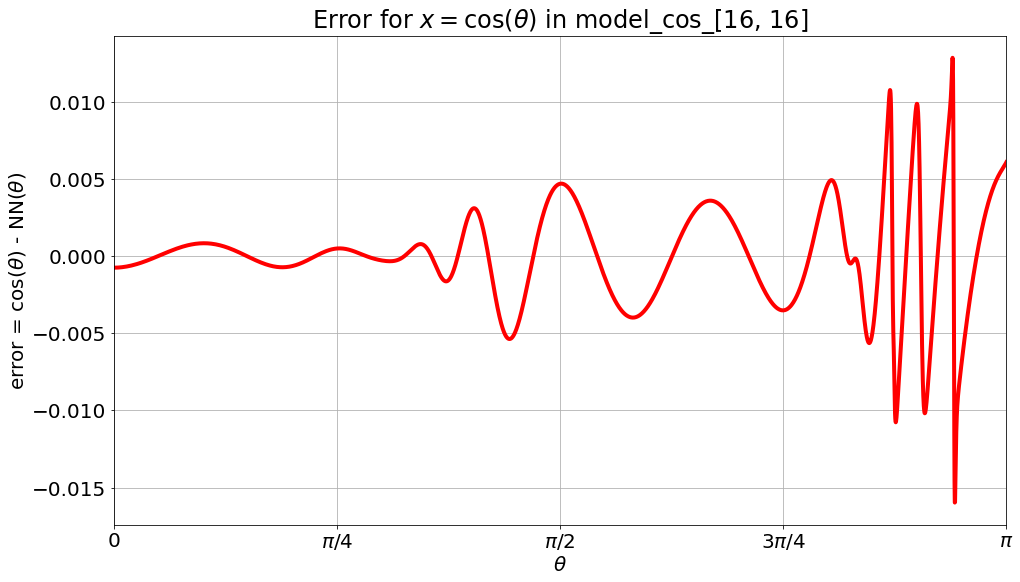

In [43]:
fig, ax = plot_error_cos(model_cos_16_16, theta)

## Neural networks for $\theta = \arccos(y)$

## Functions for visualizing neural network outputs $\theta = \arccos(y)$

In [44]:
def plot_pred_arccos(model, x):
    # Predictions of the model
    theta_pred = model.predict(x)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \\arccos(x)$ for {model.name}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(0.0, np.pi)
    ax.set_yticks(np.linspace(0.0, np.pi, 5))
    ax.set_yticklabels(['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(x, theta, color='blue', label='$\\arccos(x)$', linewidth=4.0)
    ax.plot(x, theta_pred, color='red', label='NN$(x)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [45]:
def plot_error_arccos(model, x):
    # Predictions of the model
    theta_pred = model.predict(x)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error in $\\theta = \\arccos(x)$ for {model.name}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(x, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

### Network Design 1: [64]

In [48]:
model_arccos_64 = make_model_odd(func_name='arccos', 
                                 input_name = 'x',
                                 output_name='theta', 
                                 hidden_sizes=[64])

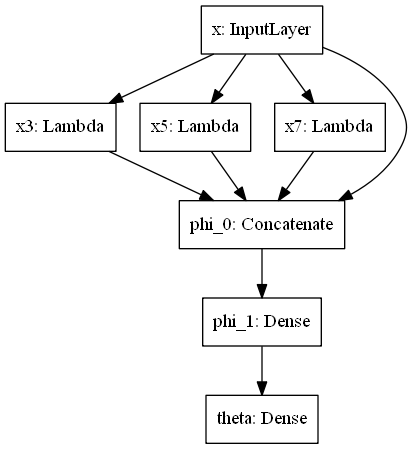

In [49]:
keras.utils.plot_model(model_arccos_64)

In [50]:
model_arccos_64.summary()

Model: "model_arccos_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________________________
x7 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________

In [51]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-4)

try:
    model_arccos_64.load_weights('../models/polar/model_arccos_[64].h5')
    model_arccos_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arccos_64 = vartbl['hist_arccos_64']
    print('Loaded model_arccos_64.')
except:
    hist = compile_and_fit(model=model_arccos_64, 
                           ds=ds_c2p, 
                           epochs=10000,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arccos_64 = hist.history
    vartbl['hist_arccos_64'] = hist_arccos_64
    save_vartbl(vartbl, fname)

W0623 16:20:11.805162 37168 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 0001; loss 3.07e+00; elapsed 0:00:00
Epoch 0500; loss 1.01e+00; elapsed 0:00:07
Epoch 1000; loss 1.43e-01; elapsed 0:00:14
Epoch 1500; loss 7.90e-03; elapsed 0:00:21
Epoch 2000; loss 4.13e-03; elapsed 0:00:28
Epoch 2500; loss 3.69e-03; elapsed 0:00:35
Epoch 3000; loss 3.27e-03; elapsed 0:00:42
Epoch 3500; loss 2.82e-03; elapsed 0:00:49
Epoch 4000; loss 2.37e-03; elapsed 0:00:56
Epoch 4500; loss 1.96e-03; elapsed 0:01:03
Epoch 5000; loss 1.60e-03; elapsed 0:01:10
Epoch 5500; loss 1.31e-03; elapsed 0:01:17
Epoch 6000; loss 1.09e-03; elapsed 0:01:24
Epoch 6500; loss 9.31e-04; elapsed 0:01:31
Epoch 7000; loss 8.16e-04; elapsed 0:01:39
Epoch 7500; loss 7.28e-04; elapsed 0:01:46
Epoch 8000; loss 6.58e-04; elapsed 0:01:53
Epoch 8500; loss 6.01e-04; elapsed 0:02:00
Epoch 9000; loss 5.54e-04; elapsed 0:02:07
Epoch 9500; loss 5.13e-04; elapsed 0:02:14
Epoch 10000; loss 4.75e-04; elapsed 0:02:20


In [52]:
model_arccos_64.evaluate(ds_c2p)

1/1 [==============================] - 0s 88ms/step - loss: 4.7522e-04 - mean_absolute_error: 0.0162


[0.0004752247768919915, 0.016163599]

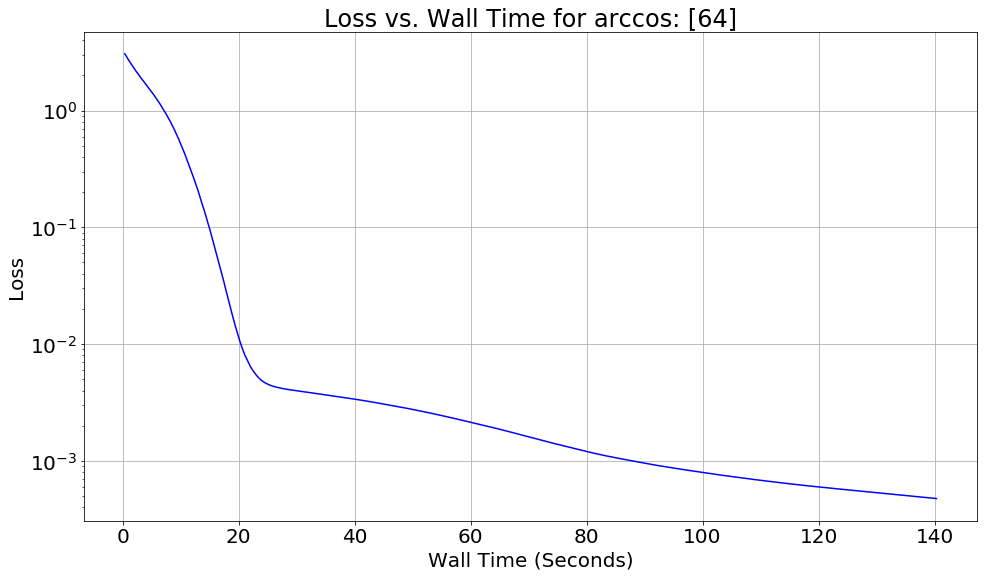

In [53]:
fig, ax = plot_loss_hist(hist_arccos_64, 'arccos: [64]')

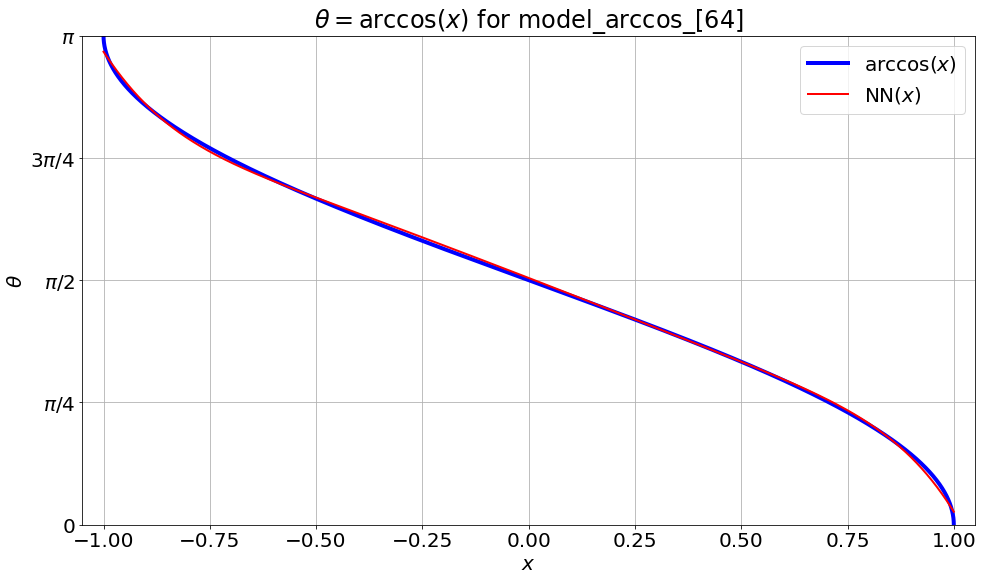

In [54]:
fig, ax = plot_pred_arccos(model_arccos_64, x)

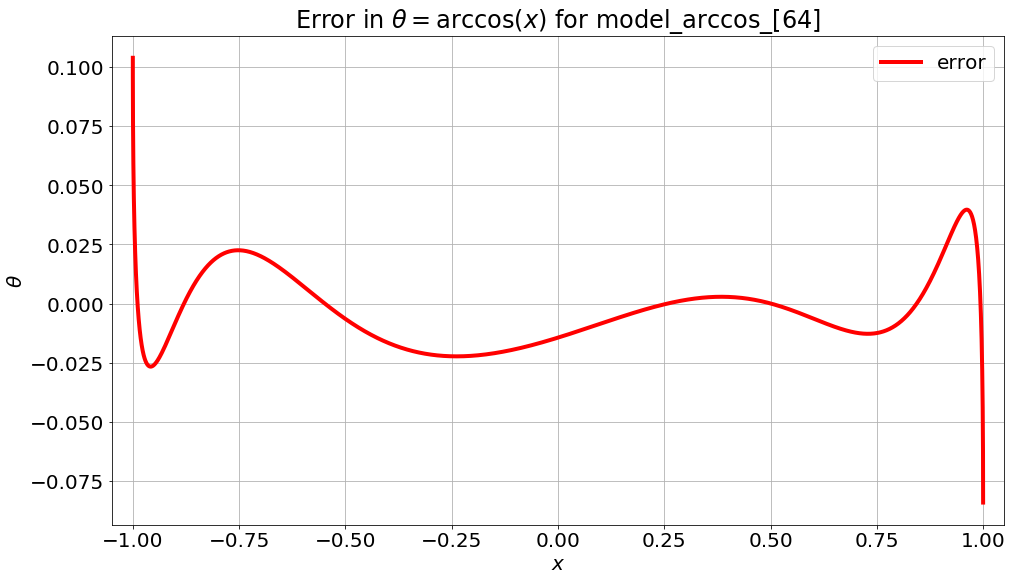

In [55]:
fig, ax = plot_error_arccos(model_arccos_64, x)

### Network Design 2: [16, 16]

In [58]:
model_arccos_16_16 = make_model_odd(func_name='arccos', 
                                    input_name = 'x',
                                    output_name='theta', 
                                    hidden_sizes=[16, 16])

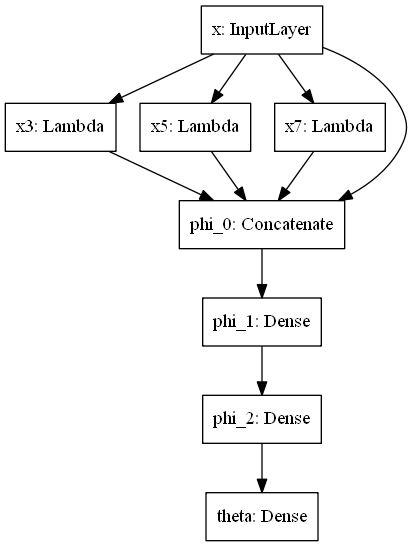

In [59]:
keras.utils.plot_model(model_arccos_16_16)

In [60]:
model_arccos_16_16.summary()

Model: "model_arccos_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________________________
x7 (Lambda)                     (None, 1)            0           x[0][0]                          
______________________________________________________________________________

In [61]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arccos_16_16.load_weights('../models/polar/model_arccos_[16, 16].h5')
    model_arccos_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arccos_16_16 = vartbl['hist_arccos_16_16']
    print('Loaded model_arccos_16_16.')
except:
    hist = compile_and_fit(model=model_arccos_16_16, 
                           ds=ds_c2p, 
                           epochs=10000,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arccos_16_16 = hist.history
    vartbl['hist_arccos_16_16'] = hist_arccos_16_16
    save_vartbl(vartbl, fname)

W0623 16:23:17.978858 37168 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 0001; loss 3.57e+00; elapsed 0:00:00
Epoch 0500; loss 5.33e-03; elapsed 0:00:08
Epoch 1000; loss 3.27e-03; elapsed 0:00:16
Epoch 1500; loss 2.29e-03; elapsed 0:00:24
Epoch 2000; loss 1.53e-03; elapsed 0:00:32
Epoch 2500; loss 9.00e-04; elapsed 0:00:40
Epoch 3000; loss 6.02e-04; elapsed 0:00:47
Epoch 3500; loss 4.79e-04; elapsed 0:00:55
Epoch 4000; loss 4.06e-04; elapsed 0:01:03
Epoch 4500; loss 3.57e-04; elapsed 0:01:11
Epoch 5000; loss 3.23e-04; elapsed 0:01:18
Epoch 5500; loss 2.99e-04; elapsed 0:01:26
Epoch 6000; loss 2.80e-04; elapsed 0:01:34
Epoch 6500; loss 2.59e-04; elapsed 0:01:42
Epoch 7000; loss 2.27e-04; elapsed 0:01:49
Epoch 7500; loss 1.85e-04; elapsed 0:01:57
Epoch 8000; loss 1.43e-04; elapsed 0:02:05
Epoch 8500; loss 1.11e-04; elapsed 0:02:13
Epoch 9000; loss 9.20e-05; elapsed 0:02:20
Epoch 9500; loss 8.22e-05; elapsed 0:02:28
Epoch 10000; loss 7.72e-05; elapsed 0:02:35


In [62]:
model_arccos_16_16.evaluate(ds_c2p)

1/1 [==============================] - 0s 113ms/step - loss: 7.7177e-05 - mean_absolute_error: 0.0048


[7.717669359408319e-05, 0.0047948295]

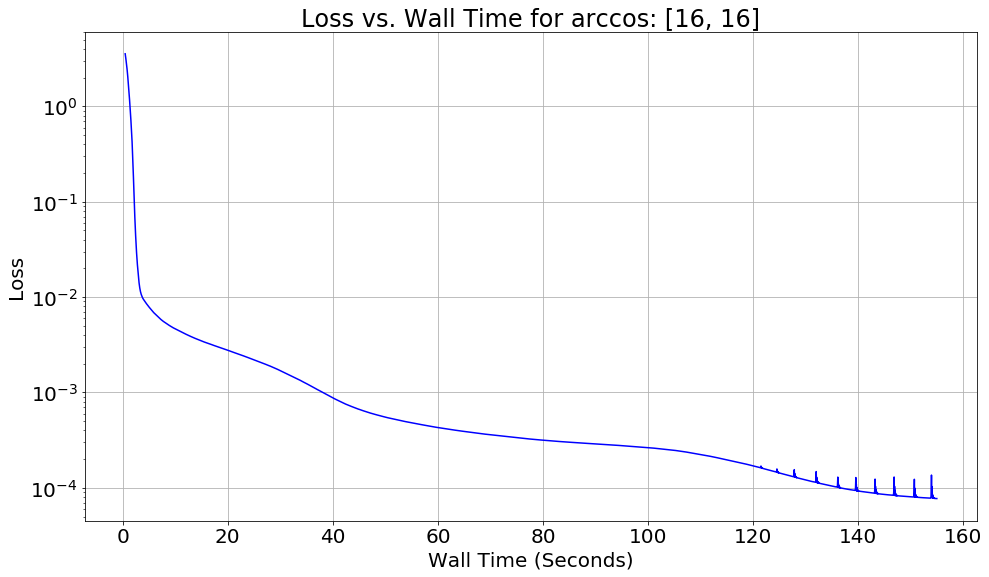

In [63]:
fig, ax = plot_loss_hist(hist_arccos_16_16, 'arccos: [16, 16]')

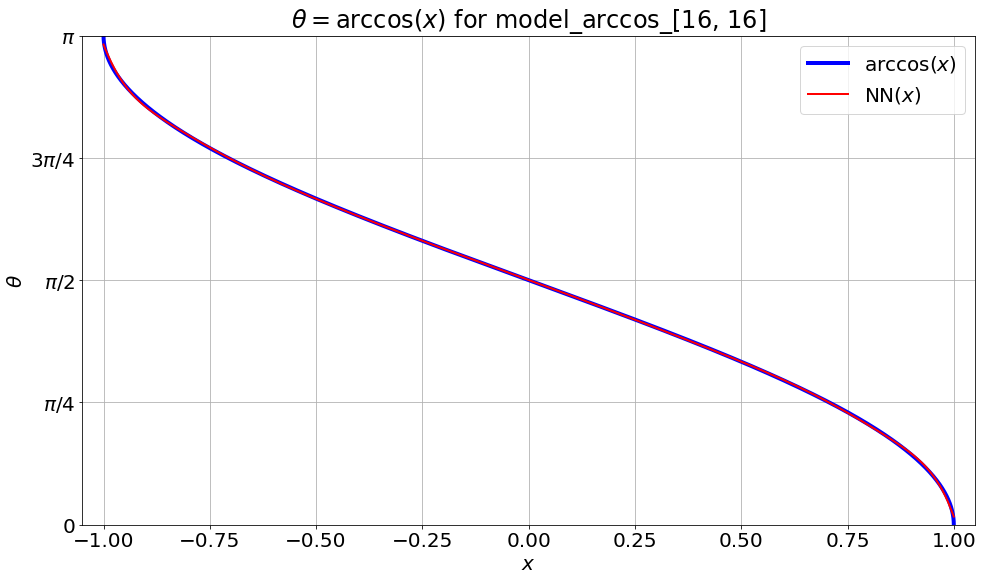

In [65]:
fig, ax = plot_pred_arccos(model_arccos_16_16, x)

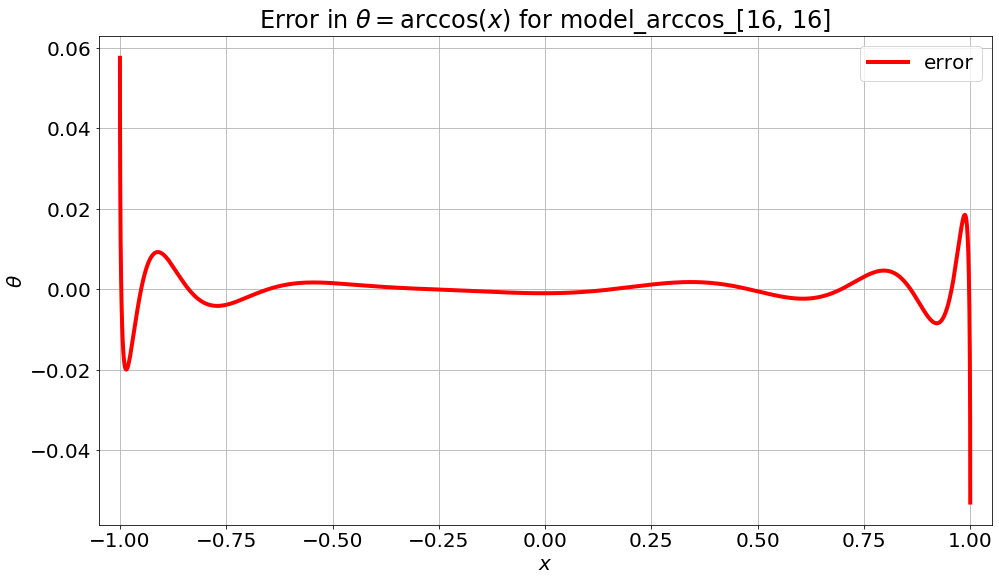

In [67]:
fig, ax = plot_error_arccos(model_arccos_16_16, x)

In [68]:
# copies of model instances
model_cos = keras.models.clone_model(model_cos_16_16)
model_cos.set_weights(model_cos_16_16.get_weights())
model_arccos = keras.models.clone_model(model_arccos_16_16)
model_arccos.set_weights(model_arccos_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_cos._name = 'model_cos'
model_arccos._name = 'model_arccos'

In [69]:
model_p2p, model_c2c = make_model_autoencoder(
    model_p2c = model_cos,
    model_c2p = model_arccos)

In [70]:
model_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_p2p.evaluate(ds_p2p)

1/1 [==============================] - 0s 128ms/step - loss: 2.8535e-04 - mean_absolute_error: 0.0085


[0.0002853535988833755, 0.008520985]

In [71]:
model_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_c2c.evaluate(ds_c2c)

1/1 [==============================] - 0s 152ms/step - loss: 1.2512e-05 - mean_absolute_error: 0.0027


[1.2512400644482113e-05, 0.0027150917]